In [31]:
import dask.dataframe as dd
import networkx as nx
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from graph_reinforcement_learning_using_blockchain_data import config

config.load_dotenv()

True

In [32]:
def parse_logs(s: str):
    safe_globals = {
        "__builtins__": {},
        "AttributeDict": lambda d: d,  # return the dict directly
        "HexBytes": lambda x: x,  # return the string argument
    }
    try:
        return eval(s, safe_globals)
    except Exception as e:
        print("Error parsing logs:", e)
        return []

In [33]:
dd_class1 = dd.read_csv(
    config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "arbitrages_with_receipts.csv",
    dtype={
        "end_amount": "object",
        "error": "object",
        "profit_amount": "object",
        "start_amount": "object",
    },
)
dd_class1["receipt"] = dd_class1["receipt"].apply(parse_logs, meta=("logs", "object"))
dd_class1["logs"] = dd_class1["receipt"].apply(lambda x: x["logs"], meta=("logs", "object"))

In [34]:
dd_class0 = dd.read_csv(
    config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "class0_with_receipts.csv"
)
dd_class0["receipt"] = dd_class0["receipt"].apply(parse_logs, meta=("logs", "object"))
dd_class0["logs"] = dd_class0["receipt"].apply(lambda x: x["logs"], meta=("logs", "object"))

In [35]:
print(dd_class0["receipt"].head())

0    {'transactionHash': '0x8e90ecb85b61af368db0154...
1    {'transactionHash': '0xd83c25449d0766a18945f10...
2    {'transactionHash': '0x8b434ba680a93cc0e85a7c4...
3    {'transactionHash': '0x8d3b8e46a66a909643f2bb7...
4    {'transactionHash': '0x25908bad48b2353a1da142d...
Name: receipt, dtype: object


## Features edges

In [36]:
# See notebook 2.01-lte-signatures-arbitrages_with_logs.ipynb
top_class0_signatures = [
    "0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef",
    "0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925",
    "0x1c411e9a96e071241c2f21f7726b17ae89e3cab4c78be50e062b03a9fffbbad1",
    "0xd78ad95fa46c994b6551d0da85fc275fe613ce37657fb8d5e3d130840159d822",
    "0xe1fffcc4923d04b559f4d29a8bfc6cda04eb5b0d3c460751c2402c5c5cc9109c",
    "0x7fcf532c15f0a6db0bd6d0e038bea71d30d808c7d98cb3bf7268a95bf5081b65",
    "0xc42079f94a6350d7e6235f29174924f928cc2ac818eb64fed8004e115fbcca67",
    "0xe9149e1b5059238baed02fa659dbf4bd932fbcf760a431330df4d934bc942f37",
    "0x9d9af8e38d66c62e2c12f0225249fd9d721c54b83f48d9352c97c6cacdcb6f31",
    "0x17307eab39ab6107e8899845ad3d59bd9653f200f220920489ca2b5937696c31",
]

top_class1_signatures = [
    "0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef",
    "0x1c411e9a96e071241c2f21f7726b17ae89e3cab4c78be50e062b03a9fffbbad1",
    "0xd78ad95fa46c994b6551d0da85fc275fe613ce37657fb8d5e3d130840159d822",
    "0xc42079f94a6350d7e6235f29174924f928cc2ac818eb64fed8004e115fbcca67",
    "0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925",
    "0x7fcf532c15f0a6db0bd6d0e038bea71d30d808c7d98cb3bf7268a95bf5081b65",
    "0x19b47279256b2a23a1665c810c8d55a1758940ee09377d4f8d26497a3577dc83",
    "0x908fb5ee8f16c6bc9bc3690973819f32a4d4b10188134543c88706e0e1d43378",
    "0xddac40937f35385a34f721af292e5a83fc5b840f722bff57c2fc71adba708c48",
    "0x8201aa3f00000000000000000000000000000000000000000000000000000000",
]

top_signatures = list(set(top_class0_signatures + top_class1_signatures))

In [37]:
def extract_receipt_features(tx_receipt, top_signatures):
    features = {}
    features["transactionHash"] = tx_receipt.get("transactionHash")
    features["blockNumber"] = tx_receipt.get("blockNumber", 0)
    features["gasUsed"] = tx_receipt.get("gasUsed", 0)
    features["cumulativeGasUsed"] = tx_receipt.get("cumulativeGasUsed", 0)
    features["transactionIndex"] = tx_receipt.get("transactionIndex", 0)
    features["effectiveGasPrice"] = tx_receipt.get("effectiveGasPrice", 0)
    features["status"] = tx_receipt.get("status", 0)
    features["fee"] = features["gasUsed"] * features["effectiveGasPrice"]

    features["from"] = tx_receipt.get("from", None)
    features["to"] = tx_receipt.get("to", None)

    logs = tx_receipt.get("logs", [])
    features["num_logs"] = len(logs)

    event_counts = {}
    for log in logs:
        topics = log.get("topics", [])
        if topics:
            sig = topics[0].hex() if hasattr(topics[0], "hex") else str(topics[0])
            event_counts[sig] = event_counts.get(sig, 0) + 1

    for sig in top_signatures:
        features[f"dummy_{sig[:10]}"] = 1 if sig in event_counts else 0

    return features

In [38]:
dd_features_class0 = dd_class0["receipt"].apply(
    lambda row: extract_receipt_features(row, top_signatures),
    axis=0,
    meta=("features", "object"),
)
dd_features_class1 = dd_class1["receipt"].apply(
    lambda row: extract_receipt_features(row, top_signatures),
    axis=0,
    meta=("features", "object"),
)

In [39]:
features_class0 = dd_features_class0.compute()
features_class1 = dd_features_class1.compute()

In [40]:
df_features_class0 = pd.DataFrame(list(features_class0))
df_features_class1 = pd.DataFrame(list(features_class1))

In [41]:
df_features_class0["label"] = 0
df_features_class1["label"] = 1

In [42]:
df_features_edges = pd.concat([df_features_class0, df_features_class1])

In [43]:
df_features_edges.describe()

,blockNumber,gasUsed,cumulativeGasUsed,transactionIndex,effectiveGasPrice,status,fee,num_logs,dummy_0xddf252ad,dummy_0xc42079f9,...,dummy_0x8201aa3f,dummy_0x1c411e9a,dummy_0xddac4093,dummy_0xd78ad95f,dummy_0x7fcf532c,dummy_0x9d9af8e3,dummy_0xe9149e1b,dummy_0x19b47279,dummy_0x8c5be1e5,label
count,2.284980e+05,2.284980e+05,2.284980e+05,228498.000000,2.284980e+05,228498.000000,2.284980e+05,228498.000000,228498.000000,228498.000000,...,228498.000000,228498.000000,228498.000000,228498.000000,228498.000000,228498.000000,228498.000000,228498.000000,228498.000000,228498.000000
mean,1.714544e+07,1.638710e+05,5.497698e+06,54.450551,8.078694e+10,0.979435,1.556759e+16,6.103633,0.718886,0.387588,...,0.013720,0.501265,0.003085,0.500958,0.050889,0.010074,0.001094,0.020915,0.083261,0.496980
std,1.673162e+05,2.637874e+05,5.766008e+06,64.913711,3.166480e+11,0.141922,6.660117e+16,8.788783,0.449544,0.487201,...,0.116326,0.499999,0.055460,0.500000,0.219771,0.099865,0.033059,0.143100,0.276277,0.499992
min,1.695060e+07,2.100000e+04,2.100000e+04,0.000000,1.152221e+10,0.000000,3.150000e+14,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.699927e+07,4.710700e+04,1.171730e+06,6.000000,2.366379e+10,1.000000,1.540639e+15,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.708752e+07,1.400650e+05,3.328971e+06,27.000000,3.522781e+10,1.000000,4.939205e+15,6.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.727266e+07,2.057638e+05,8.167795e+06,89.000000,6.352686e+10,1.000000,1.196167e+16,8.000000,1.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.751777e+07,2.402678e+07,2.999747e+07,910.000000,3.810702e+13,1.000000,7.302631e+18,960.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
df_features_edges.head()

,transactionHash,blockNumber,gasUsed,cumulativeGasUsed,transactionIndex,effectiveGasPrice,status,fee,from,to,...,dummy_0x8201aa3f,dummy_0x1c411e9a,dummy_0xddac4093,dummy_0xd78ad95f,dummy_0x7fcf532c,dummy_0x9d9af8e3,dummy_0xe9149e1b,dummy_0x19b47279,dummy_0x8c5be1e5,label
0,0x8e90ecb85b61af368db0154830453552f0c27e0e1812...,17005294,153529,10750253,111,19150328915,1,2940130847991035,0x832aC338d06f5A438f3340B724c08C44e744e9c2,0x00000000000001ad428e4906aE43D8F9852d0dD6,...,0,0,0,0,0,1,0,0,1,0
1,0xd83c25449d0766a18945f10aff7912f2ff492f0234a8...,16962424,123497,229900,1,139502435999,1,17228132338568503,0x080086911D8c78008800FAE75871a657b77d0082,0x0000E0Ca771e21bD00057F54A68C30D400000000,...,0,1,0,1,0,0,0,0,0,0
2,0x8b434ba680a93cc0e85a7c431e5b35a8efb60ef05c24...,16993741,21000,15838026,183,22098066562,1,464059397802000,0xE991Dc594Ea50b7B83be1B0a44Fd138582c04383,0xD8A5859Ce6f265D376922Dc27f70b804cc65f49E,...,0,0,0,0,0,0,0,0,0,0
3,0x8d3b8e46a66a909643f2bb7497b18c954fc22fa5bd5c...,16972733,46817,14885776,165,18825121161,1,881335697394537,0xCA8ba7d3f798d1872A8C05c5358a1b24a4d3Ac64,0x2b591e99afE9f32eAA6214f7B7629768c40Eeb39,...,0,0,0,0,0,0,0,0,0,0
4,0x25908bad48b2353a1da142da6f0a19c015dfbac5245f...,17028487,32215,3160909,48,19660583885,1,633365709855275,0x8FEf490D614fCe8B93Bd6F28835dD35a8B3229a9,0xBA50933C268F567BDC86E1aC131BE072C6B0b71a,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# nan values
df_features_edges.isna().sum()

transactionHash        0
blockNumber            0
gasUsed                0
cumulativeGasUsed      0
transactionIndex       0
effectiveGasPrice      0
status                 0
fee                    0
from                   0
to                   117
num_logs               0
dummy_0xddf252ad       0
dummy_0xc42079f9       0
dummy_0xe1fffcc4       0
dummy_0x17307eab       0
dummy_0x908fb5ee       0
dummy_0x8201aa3f       0
dummy_0x1c411e9a       0
dummy_0xddac4093       0
dummy_0xd78ad95f       0
dummy_0x7fcf532c       0
dummy_0x9d9af8e3       0
dummy_0xe9149e1b       0
dummy_0x19b47279       0
dummy_0x8c5be1e5       0
label                  0
dtype: int64

In [46]:
df_features_edges.dropna(inplace=True)

In [47]:
len(df_features_edges)

228381

In [48]:
df_features_edges["blockNumber"].max() - df_features_edges["blockNumber"].min()

567172

In [49]:
def plot_hist(df, label_name):
    sns.set(style="whitegrid")

    plt.figure(figsize=(8, 6))
    ax = sns.histplot(df[label_name], bins=2, discrete=True)

    for p in ax.patches:
        ax.annotate(
            f"{int(p.get_height())}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 10),
            textcoords="offset points",
        )

    ax.set_xticks([0, 1])
    ax.set_xlabel("Class Label")
    ax.set_ylabel("Count")
    ax.set_title("Histogram of Class Labels")

    plt.show()

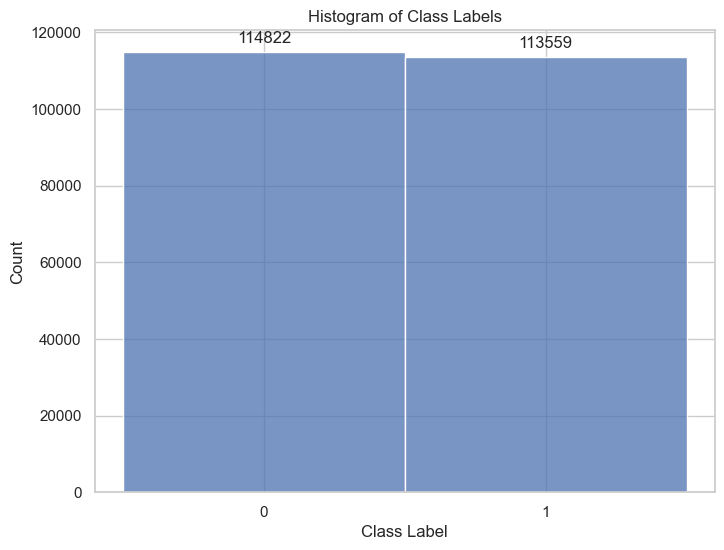

In [50]:
plot_hist(df_features_edges, "label")

In [51]:
# df_features.to_csv(
#     config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "features_edges.csv", index=False
# )

## Features nodes

In [52]:
dummy_cols = [col for col in df_features_edges.columns if col.startswith("dummy_")]

agg_dict = {
    "blockNumber": ["min", "max", "mean"],
    "gasUsed": ["sum", "mean"],
    "cumulativeGasUsed": ["sum", "mean"],
    "transactionIndex": ["min", "max", "mean"],
    "effectiveGasPrice": ["mean", "max"],
    "status": "mean",  # proportion of successful transactions
    "fee": ["sum", "mean"],
    "label": "max",  # If any transaction is arbitrage (1), then account is arbitrage
    "transactionHash": "count",  # number of transactions
    "to": pd.Series.nunique,  # number of unique recipient accounts
}

for col in dummy_cols:
    agg_dict[col] = "sum"

df_accounts = df_features_edges.groupby("from").agg(agg_dict)

df_accounts.columns = [
    "_".join(col).strip() if isinstance(col, tuple) else col for col in df_accounts.columns.values
]

df_accounts = df_accounts.rename(
    columns={
        "transactionHash_count": "num_transactions",
        "to_nunique": "unique_recipients",
        "label_max": "account_label",
    }
)

# Optionally, you can reset the index to have the account as a column
df_accounts = df_accounts.reset_index().rename(columns={"from": "account"})

In [53]:
df_accounts.head()

,account,blockNumber_min,blockNumber_max,blockNumber_mean,gasUsed_sum,gasUsed_mean,cumulativeGasUsed_sum,cumulativeGasUsed_mean,transactionIndex_min,transactionIndex_max,...,dummy_0x908fb5ee_sum,dummy_0x8201aa3f_sum,dummy_0x1c411e9a_sum,dummy_0xddac4093_sum,dummy_0xd78ad95f_sum,dummy_0x7fcf532c_sum,dummy_0x9d9af8e3_sum,dummy_0xe9149e1b_sum,dummy_0x19b47279_sum,dummy_0x8c5be1e5_sum
0,0x00000000000124d994209fbB955E0217B5C2ECA1,16969850,17299799,1.703075e+07,1119657,101787.000000,41184266,3.744024e+06,3,48,...,0,0,3,0,3,3,0,0,0,3
1,0x000000000002e6fD89aC3B5798a5d32312B8a49f,16961029,16961029,1.696103e+07,21000,21000.000000,9850199,9.850199e+06,123,123,...,0,0,0,0,0,0,0,0,0,0
2,0x0000000000055772357E58581A2A2C5C6D9E8F64,17452199,17517647,1.748020e+07,17713256,184513.083333,194719150,2.028324e+06,0,94,...,0,0,49,0,49,0,0,0,50,0
3,0x00000000000FFE26043F4C963A16612f8410A881,16979002,16979002,1.697900e+07,132305,132305.000000,12121809,1.212181e+07,147,147,...,0,0,0,0,0,0,0,0,0,1
4,0x0000000000E3C7175357AAE6FCE025bE01Aa13Ca,17241212,17241212,1.724121e+07,21000,21000.000000,17214987,1.721499e+07,71,71,...,0,0,0,0,0,0,0,0,0,0


In [54]:
len(df_accounts)

78656

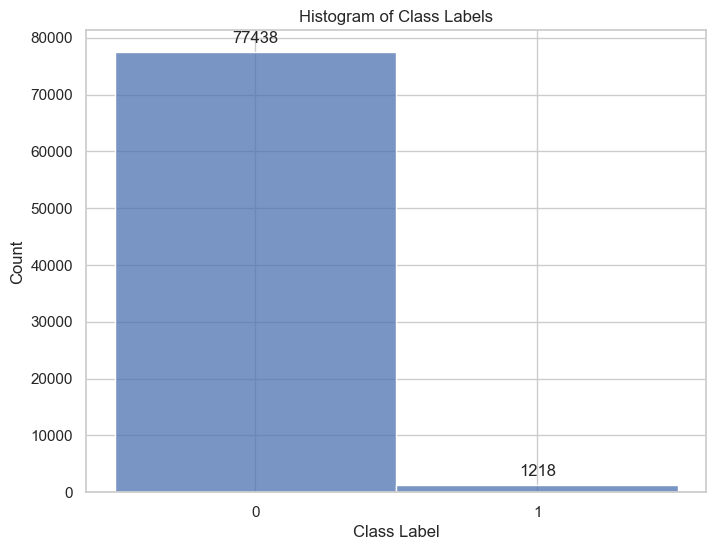

In [55]:
plot_hist(df_accounts, "account_label")

In [56]:
# df_accounts.to_csv(
#     config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "features_nodes.csv", index=False
# )

## Graph Features

In [ ]:
df_features_edges_graph = df_features_edges.copy()

G = nx.from_pandas_edgelist(
    df_features_edges_graph, source="from", target="to", create_using=nx.DiGraph()
)

in_degrees = dict(G.in_degree())
out_degrees = dict(G.out_degree())

df_features_edges_graph["from_in_degree"] = df_features_edges_graph["from"].apply(
    lambda x: in_degrees.get(x, 0)
)
df_features_edges_graph["from_out_degree"] = df_features_edges_graph["from"].apply(
    lambda x: out_degrees.get(x, 0)
)
df_features_edges_graph["to_in_degree"] = df_features_edges_graph["to"].apply(
    lambda x: in_degrees.get(x, 0)
)
df_features_edges_graph["to_out_degree"] = df_features_edges_graph["to"].apply(
    lambda x: out_degrees.get(x, 0)
)

G_undirected = G.to_undirected()


def common_neighbors_count(u, v):
    return len(list(nx.common_neighbors(G_undirected, u, v)))


df_features_edges_graph["common_neighbors"] = df_features_edges_graph.apply(
    lambda row: common_neighbors_count(row["from"], row["to"]), axis=1
)

clustering = nx.clustering(G_undirected)

df_features_edges_graph["from_clustering"] = df_features_edges_graph["from"].apply(
    lambda x: clustering.get(x, 0)
)
df_features_edges_graph["to_clustering"] = df_features_edges_graph["to"].apply(
    lambda x: clustering.get(x, 0)
)

In [58]:
df_features_edges_graph.head()

,transactionHash,blockNumber,gasUsed,cumulativeGasUsed,transactionIndex,effectiveGasPrice,status,fee,from,to,...,dummy_0x19b47279,dummy_0x8c5be1e5,label,from_in_degree,from_out_degree,to_in_degree,to_out_degree,common_neighbors,from_clustering,to_clustering
0,0x8e90ecb85b61af368db0154830453552f0c27e0e1812...,17005294,153529,10750253,111,19150328915,1,2940130847991035,0x832aC338d06f5A438f3340B724c08C44e744e9c2,0x00000000000001ad428e4906aE43D8F9852d0dD6,...,0,1,0,0,1,2578,0,0,0.0,3.010459e-07
1,0xd83c25449d0766a18945f10aff7912f2ff492f0234a8...,16962424,123497,229900,1,139502435999,1,17228132338568503,0x080086911D8c78008800FAE75871a657b77d0082,0x0000E0Ca771e21bD00057F54A68C30D400000000,...,0,0,0,0,2,14,0,0,0.0,0.000000e+00
2,0x8b434ba680a93cc0e85a7c431e5b35a8efb60ef05c24...,16993741,21000,15838026,183,22098066562,1,464059397802000,0xE991Dc594Ea50b7B83be1B0a44Fd138582c04383,0xD8A5859Ce6f265D376922Dc27f70b804cc65f49E,...,0,0,0,0,1,1,0,0,0.0,0.000000e+00
3,0x8d3b8e46a66a909643f2bb7497b18c954fc22fa5bd5c...,16972733,46817,14885776,165,18825121161,1,881335697394537,0xCA8ba7d3f798d1872A8C05c5358a1b24a4d3Ac64,0x2b591e99afE9f32eAA6214f7B7629768c40Eeb39,...,0,0,0,0,1,192,0,0,0.0,0.000000e+00
4,0x25908bad48b2353a1da142da6f0a19c015dfbac5245f...,17028487,32215,3160909,48,19660583885,1,633365709855275,0x8FEf490D614fCe8B93Bd6F28835dD35a8B3229a9,0xBA50933C268F567BDC86E1aC131BE072C6B0b71a,...,0,0,0,1,1,7,0,0,0.0,0.000000e+00


In [60]:
df_features_edges_graph.to_csv(
    config.PROCESSED_DATA_DIR / "flashbots" / "Q2_2023" / "features_edges_graph.csv", index=False
)